# <ins>Algorithme de recherche de Grover a plusieurs participants</ins>

****

_Contexte_: On veut trouver l'intersection entre plusieurs calendriers.

_Resume_: L'idee est d'appliquer l'algorithme de recherche de Grover et de le tranposer a plusieurs participants.

_Exemple_: Dans ce rapport, on montre l'algorithme avec 3 participants. Le circuit est compose de 4 registres, 3 registres quantique et un registre classique. les trois registres quantiques representent les 3 participants. Chaque participants a donc ses qubits a lui. La quantite de qubits pour chaque participants est egale a

$$
  nqubits = log_2(n) + p - 1
$$

n: longueur du calendrier <br>
p: nombre de participants <br>
****

### **Import la librairie qiskit et quelques librairies de math.**

In [1]:
# uncomment on first run to install qiskit library
##############################################
#!pip install qiskit
#!pip install qiskit-ibm-runtime
##############################################

#initialization
import matplotlib.pyplot as plt  # plotting the results
import numpy as np               # create and manage arrays
# import math                      # using more complexe math operations

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex, plot_gate_map
from qiskit.circuit.library import MCMT, MCMTVChain, Diagonal

# import math tools
from math import floor, ceil, sqrt, pi, log2   # using more complexe math operations

## **Declaration de fonctions**
___

### **Fonctions d'utilite**

Les fonctions d'utilite sont des fonctions qui sont utilise tout au long du protocole. Elles servent a facilite l'ecriture du code 

In [2]:
#######################################################################################################    
    
#      UTILITY
    
#######################################################################################################

# Initialize working qubits to |S> state
def Initialize_S(qc, first, last):
    """Apply a H-gate to 'qubits' in qc"""
    for q in range(last - first):
        qc.h(q + first)
    return qc

# return 2 dimensional array  that contains the bit number of each position:
# input = 4 -> output = [[0, 0], [0, 1], [1, 0], [1, 1]]
def CalculateBinary(number):
    array = []
    num_bits = ceil(log2(number))
    for num in range(number):
         array.append([(num >> bit) & 1 for bit in range(num_bits - 1, -1, -1)])
    return array

# return 2 dimensional array that write the qubit positions that contain a 0:
# input = [[0, 0], [0, 1], [1, 0], [1, 1]] -> output = [[0, 1], [0], [1], []]
def ExtractPosition(array):
    newArray2 = []
    for i in array:
        newArray1 = []
        q = 0
        for y in i:
            if y == 0:
                newArray1.append(q)
            q += 1
        newArray2.append(newArray1)
    return newArray2

# measure i qubits for i classical bit 
def MesureQubits(qc, nqubits):
    for i in range(nqubits):
        qc.measure(i, i)

# Ensure that two participants has their calendar of the same size        
def CheckCalendar(a, b):
    if len(a) != len(b):
        raise Exception("the two calendar must be the same size")

# swap all working qubits from the messenger to the receiver 
# messenger and receiver are the index of the participant
def SwapAll(qc, nqubits, messenger, receiver):
    for i in range(nqubits):
        qc.swap(i + nqubits * messenger, i + nqubits * receiver)

# apply the X gates in the circuit on the qubits that must be conditionned to zero
def ApplyNOT(qc, pos, nqubits): 
    temp = [i for i in pos]
    if not temp:
        pass
    else:
        for i in range(len(temp)):
            temp[i] = temp[i] + nqubits
        qc.x(temp)

def InverseResults(results, threshold):
    best_results = []
    # result only consider elements over a certain threshold
    for r in results:
        if r[1] >= threshold:
            best_results.append(r[0])

    # inverse the binary result because qiskit have inversed result
    # Example: result = 001 = 1, true value = 100 = 4
    results = []
    for i in best_results:
        results.append(int(str(i)[::-1], 2))

    if not results:
        print("there are no solutions for these calendars")

    elif len(results) == 1:
        print("the solution is: ", results[0])
    else:
        print("there are", len(results),"solutions: ", results)

### **Fonctions principales pour l'implementation de Grover**

Dans l'algorithme de recherche de Grover distribue, chacun des participant doit creer un oracle. L'oracle sert a isole la ou les solutions des participants. L'idee generale est de mettre toutes les solutions en superposition et d'inverser la phase des etats solutions. Ensuite, le diffuseur va effectuer une rotation autour de l'etat $|s\rangle$. On repete le processus $ \simeq \sqrt{n}$ ou n est la taille des calendriers des participants. Le fait de repeter le processus va amplifier la probabilite de mesurer l'etat ou des etats solutions.

In [3]:
#######################################################################################################    
    
#      Grover's Oracles and diffuser
    
#######################################################################################################    

# Create the oracle circuit for Alice      
def CreateOracleAlice(qc, numPos, calendar, nqubits): 
    if (ceil(log2(len(calendar))) == floor(log2(len(calendar)))): # calendar must be a power of 2
        bits = CalculateBinary(numPos)                            # possible positions in bit
        Xpos = ExtractPosition(bits)                              # indices of the qubits to apply X-gate
        targets = nqubits - 2                                     # number of targets in multi controlled gate
        MCMTPos = []
        for i in range(nqubits - 1): 
            MCMTPos.append(i)
        i = 0
        for pos in Xpos:
            if calendar[i] == "1":
                ApplyNOT(qc, pos, 0)                              # Apply not gates where contitioning 0
                qc.append(MCMT("x", targets, 1), MCMTPos)         # Apply multi-Toffoli gate
                ApplyNOT(qc, pos, 0)                              # Apply not gates where contitioning 0
                qc.barrier()
            i += 1
    else:
        raise Exception("the calendar must be a power of 2")

# Create the oracle circuit for Bob
def CreateOracleBob(qc, numPos, calendar, nqubits): 
    if (ceil(log2(len(calendar))) == floor(log2(len(calendar)))): # calendar must be a power of 2
        bits = CalculateBinary(numPos)                            # possible positions in bit
        Xpos = ExtractPosition(bits)                              # indices of the qubits to apply X-gate
        targets = nqubits - 2                                     # number of targets in multi controlled gate
        MCMTPos = []
        for i in range(nPosQubits):
            MCMTPos.append(nqubits + i)
        MCMTPos.append(2 * nqubits - 1)                           # append the position of the qubit to condition
        i = 0
        for pos in Xpos:
            if calendar[i] == "1":
                ApplyNOT(qc, pos, nqubits)                        # Apply not gates where contitioning 0
                qc.append(MCMT("x", targets, 1), MCMTPos)         # Apply multi-Toffoli gate
                ApplyNOT(qc, pos, nqubits)                        # Apply not gates where contitioning 0
                qc.barrier()
            i += 1 
    else:
        raise Exception("the calendar must be a power of 2")

# Create the oracle circuit for Charlie
def CreateOracleCharlie(qc, numPos, calendar, nqubits): 
    if (ceil(log2(len(calendar))) == floor(log2(len(calendar)))): # calendar must be a power of 2
        bits = CalculateBinary(numPos)                            # possible positions in bit
        Xpos = ExtractPosition(bits)                              # indices of the qubits to apply X-gate
        targets = nqubits - 1                                     # number of targets in multi controlled gate
        MCMTPos = []
        for i in range(nqubits):
            MCMTPos.append(2 * nqubits + i)        
        i = 0
        for pos in Xpos:
            if calendar[i] == "1":
                ApplyNOT(qc, pos, 2 * nqubits)                    # Apply not gates where contitioning 0
                qc.append(MCMT("z", targets, 1), MCMTPos)         # Apply multi-controlled-z gate
                ApplyNOT(qc, pos, 2 * nqubits)                    # Apply not gates where contitioning 0
                qc.barrier()
            i += 1 
    else:
        raise Exception("the calendar must be a power of 2")        
        
# create a gate from the implementation of the diffuser 
def Diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)                      # multi-controlled-toffoli
    qc.h(nqubits-1)
    # apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)

    U_s = qc.to_gate()                                            # return the diffuser as a gate
    U_s.name = "Diffuser"
    return U_s

# add the diffuser to the circuit
def AddDiffuser(qc, qr, nqubits):
    array = []
    for n in range(nqubits):
        array.append(qr * nqubits + n)
    qc.append(Diffuser(nqubits), array)   

### **Implementation de Grover**
___

Dans l'exemple a trois participants, chaque participant possede $log_2(n) + 2$ qubits. Ils ont $log_2(n)$ qubits (travailleurs) en superpositions pour trouver la solution et un qubit (surplus) parmi les autres qui servira a conditionner si la position contient un "0" ou un "1". tous les participants sauf le dernier vont partager leur disponibilite avec leur qubit de surplus ce qui va permettre aux autre participants de conditionner leur propre qubit de surplus. Une fois la disponibilite stocke dans le qubit de surplus, on doit remettre les qubits travailleurs a $|s\rangle$. Finalement pour le dernier participant, il va conditionner en inversant la phase d'un qubit de surplus qu'on va amplifier avec le diffuseur. Mais avant de diffuser, on doit "nettoyer" les qubits de surplus pour avoir un resultat qui mesure seulement les qubits travailleurs.

iter =  2
nPosQubits =  3


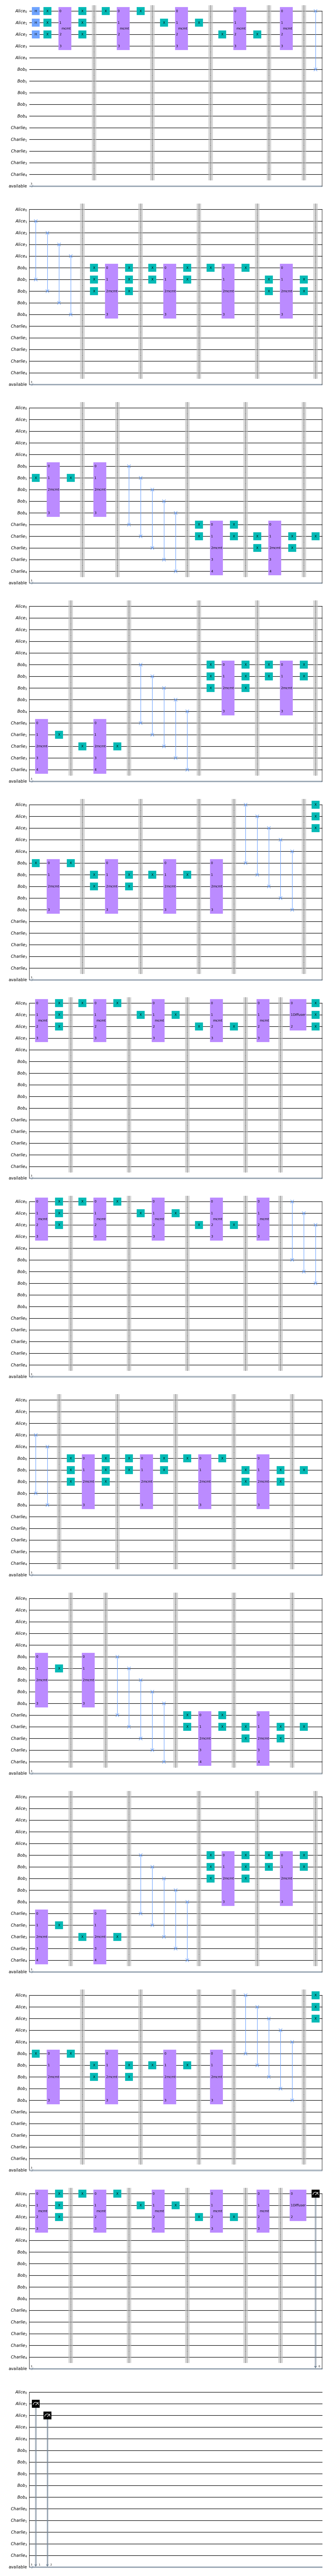

In [4]:
#######################################################################################################    
    
#      Data
    
#######################################################################################################

# 2 arbitrary calendars for Alice,  Bob and Charlie, our 3 participants
calendar_a = "10010111"
calendar_b = "11011101"
calendar_c = "01001110"

CheckCalendar(calendar_a, calendar_b)
nqubits = int(log2(len(calendar_a))) + 2  # total qubit for a participant
nPosQubits = int(log2(len(calendar_a)))   # number of qubits in superposition
numPos = len(calendar_a)                  # number of positions in the calendar

#######################################################################################################    
    
#      Create circuits
    
#######################################################################################################

qc_a = QuantumRegister(nqubits, name = "Alice")
qc_b = QuantumRegister(nqubits, name = "Bob")
qc_c = QuantumRegister(nqubits, name = "Charlie")
cr = ClassicalRegister(nPosQubits, name = "available")
qc = QuantumCircuit(qc_a, qc_b, qc_c, cr)

Initialize_S(qc, 0, nPosQubits) # Alice |s> state


#######################################################################################################    
    
#      Oracle loop
    
#######################################################################################################
nbSolutions = 1

iter = floor((ceil(sqrt(2**nPosQubits)) - 1)/nbSolutions) # if you know the number of solutions
# iter = 1 # If we don't know the number of solutions
print("iter = ", iter)

# iterate sqrt(N)
for i in range(iter):
    # oracle Alice
    CreateOracleAlice(qc, numPos, calendar_a, nqubits)

    # swap with Bob
    SwapAll(qc, nqubits, 0, 1)
    qc.barrier()

    # oracle Bob
    CreateOracleBob(qc, numPos, calendar_b, nqubits)

    #swap with Charlie
    SwapAll(qc, nqubits, 1, 2)
    qc.barrier()
    
    #oracle Charlie
    CreateOracleCharlie(qc, numPos, calendar_c, nqubits)

    #swap with Bob
    SwapAll(qc, nqubits, 2, 1)
    qc.barrier()    
    
    # oracle Bob
    CreateOracleBob(qc, numPos, calendar_b, nqubits)
    
    # swap with Alice
    SwapAll(qc, nqubits, 1, 0)
    qc.barrier()

    # oracle Alice
    CreateOracleAlice(qc, numPos, calendar_a, nqubits)

    #diffuser
    AddDiffuser(qc, 0, nPosQubits)

#################################################################################################################  
    
    
# measurement
MesureQubits(qc, nPosQubits)
print("nPosQubits = ", nPosQubits)

qc.draw("mpl")

In [5]:
# provider = IBMQ.load_account()
# provider.backends()
# backend = provider.get_backend("ibm_perth")
backend = Aer.get_backend('qasm_simulator')

# Simulate and plot results
transpiled_qc = transpile(qc, backend)
# transpiled_qc.draw("mpl")
job = backend.run(transpiled_qc)

results = list(job.result().get_counts().items())
threshold = int(1024/3) # arbitrary threshold to isolate good results

InverseResults(results, threshold)
# plot_histogram(job.result().get_counts()) #uncomment if you want to plot the results

the solution is:  5
